In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
proj_directory = "/content/drive/MyDrive/Deep Learnin Project/Brazilian Coins"

# Problem preseintation
In this dataset there are five type of coins of the brazilian currency "Real".

The coins are classified as: 
- 5 cents
- 10 cents
- 25 cents
- 50 cents
- 100 cents

There are 2190 samples for training and 544 samples for testing. The samples are RGB images 640x480

You can download the original dataset from [Kaggle Brazilian Conis Dataset](https://www.kaggle.com/datasets/volodymyrgavrysh/brazilian-coins-dataset-classification25k-images)

Ps:

Although the dataset is well organized i found some misclassified samples in the test folder and some images where the coin wasn't visible in both train and test folders. 

For this notebook the outliers have been removed

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization, ReLU, Input, concatenate, Dense
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os
%matplotlib inline

In [ ]:
train_dir = os.path.join(proj_directory, 'train_')
test_dir = os.path.join(proj_directory, 'test_')

train_images = [os.path.join(train_dir, i) for i in os.listdir(train_dir)]
test_images = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]
print(f'Train samples: {len(train_images)}')
print(f'Test samples: {len(test_images)}')

Train samples: 2190
Test samples: 544


In [ ]:
def read_image(img_path):
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    return image

In [ ]:
# Checking samples shape
# img_size = [  3 480 640]
# img_train_size = np.unique(np.array([read_image(i).shape for i in train_images]))
# img_train_size = np.unique(np.array([read_image(i).shape for i in test_images]))
# print(img_test_size)        # [  3 480 640]
# print(img_train_size)       # [  3 480 640]

In [ ]:
# - Extracting labels 5, 10, 15, 50, 100 from the files name
Y_train_labels = np.array( [int(i.split('/')[-1].split('_')[0]) for i in train_images] )
Y_test_labels = np.array( [int(i.split('/')[-1].split('_')[0]) for i in test_images] )
lbls = np.unique(Y_test_labels).tolist()

print(f'Labels in Y_train: {np.unique(Y_train_labels)}')
print(f'Labels in Y_test: {np.unique(Y_test_labels)}')

Labels in Y_train: [  5  10  25  50 100]
Labels in Y_test: [  5  10  25  50 100]


In [ ]:
def show_image(img, p=plt):
    p.imshow(img, cmap='gray')

# Inspecting data

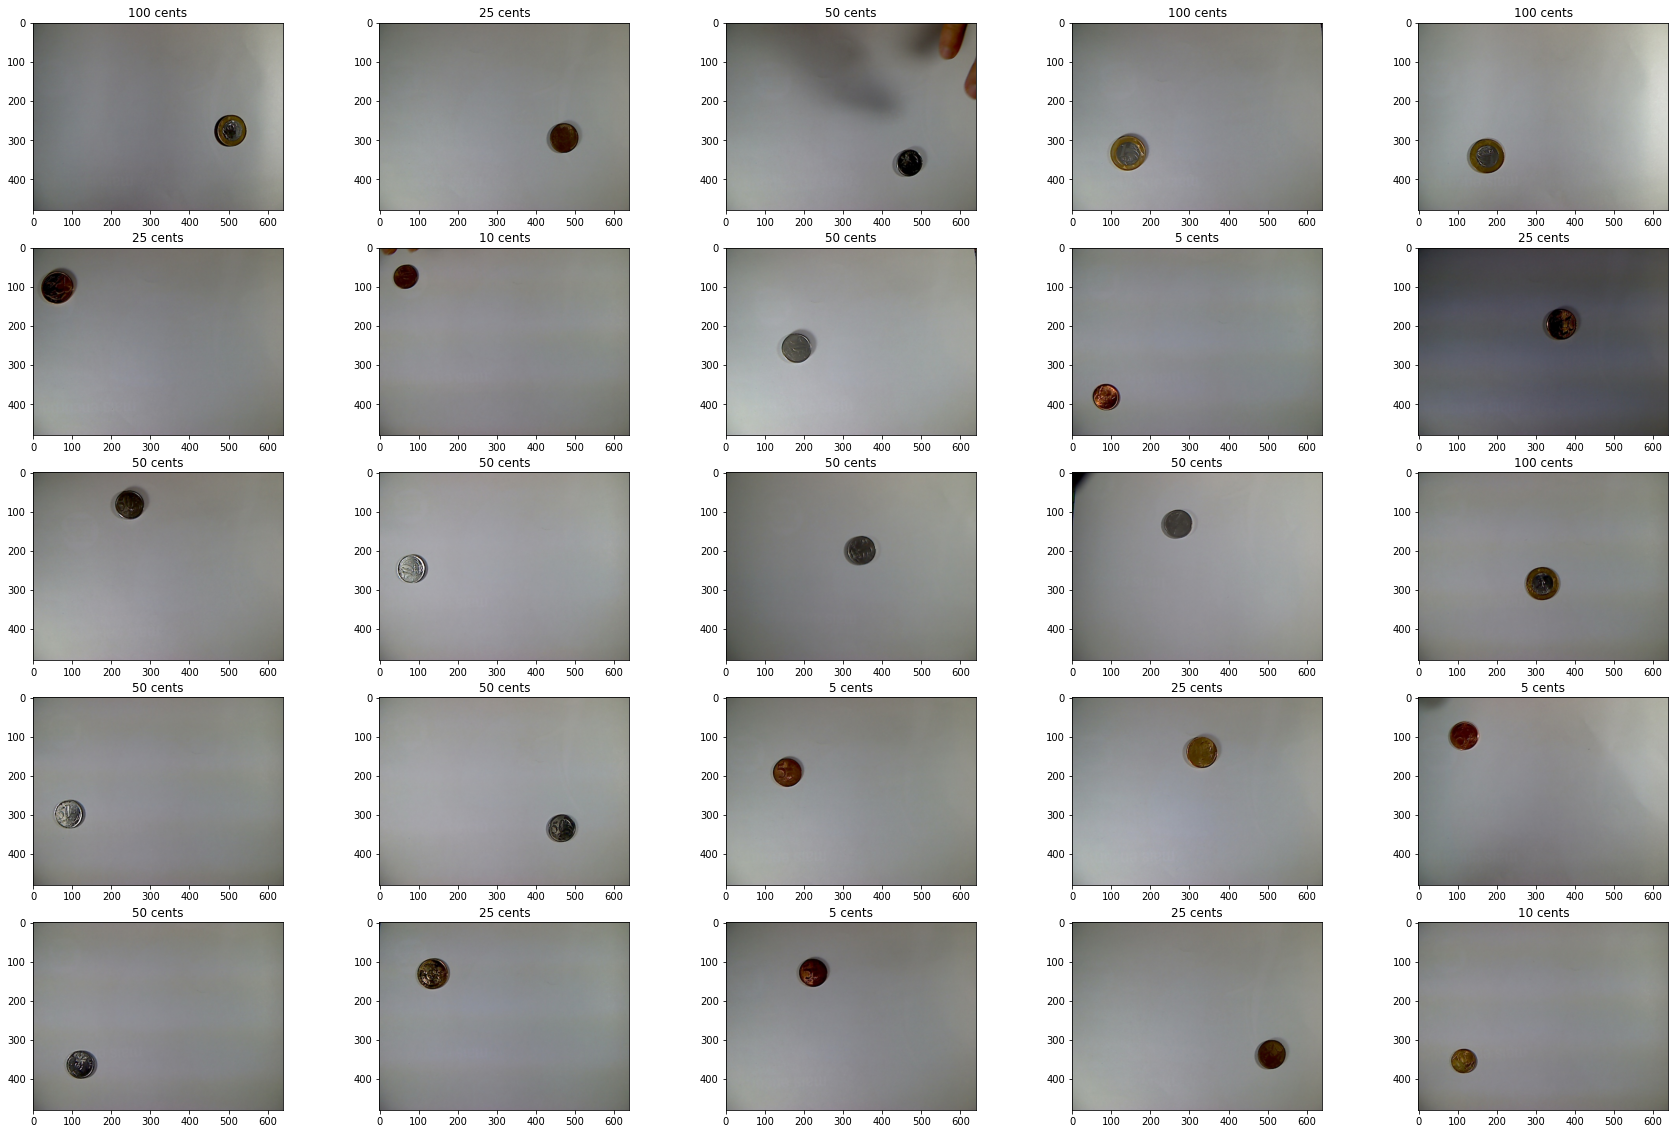

In [ ]:
# Inspecting train data
ax = plt.figure(figsize=(30, 20)).subplots(5, 5)
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, len(Y_train_labels))
        show_image(read_image(train_images[idx]), p=ax[i][j])
        ax[i][j].set_title(f'{Y_train_labels[idx]} cents')

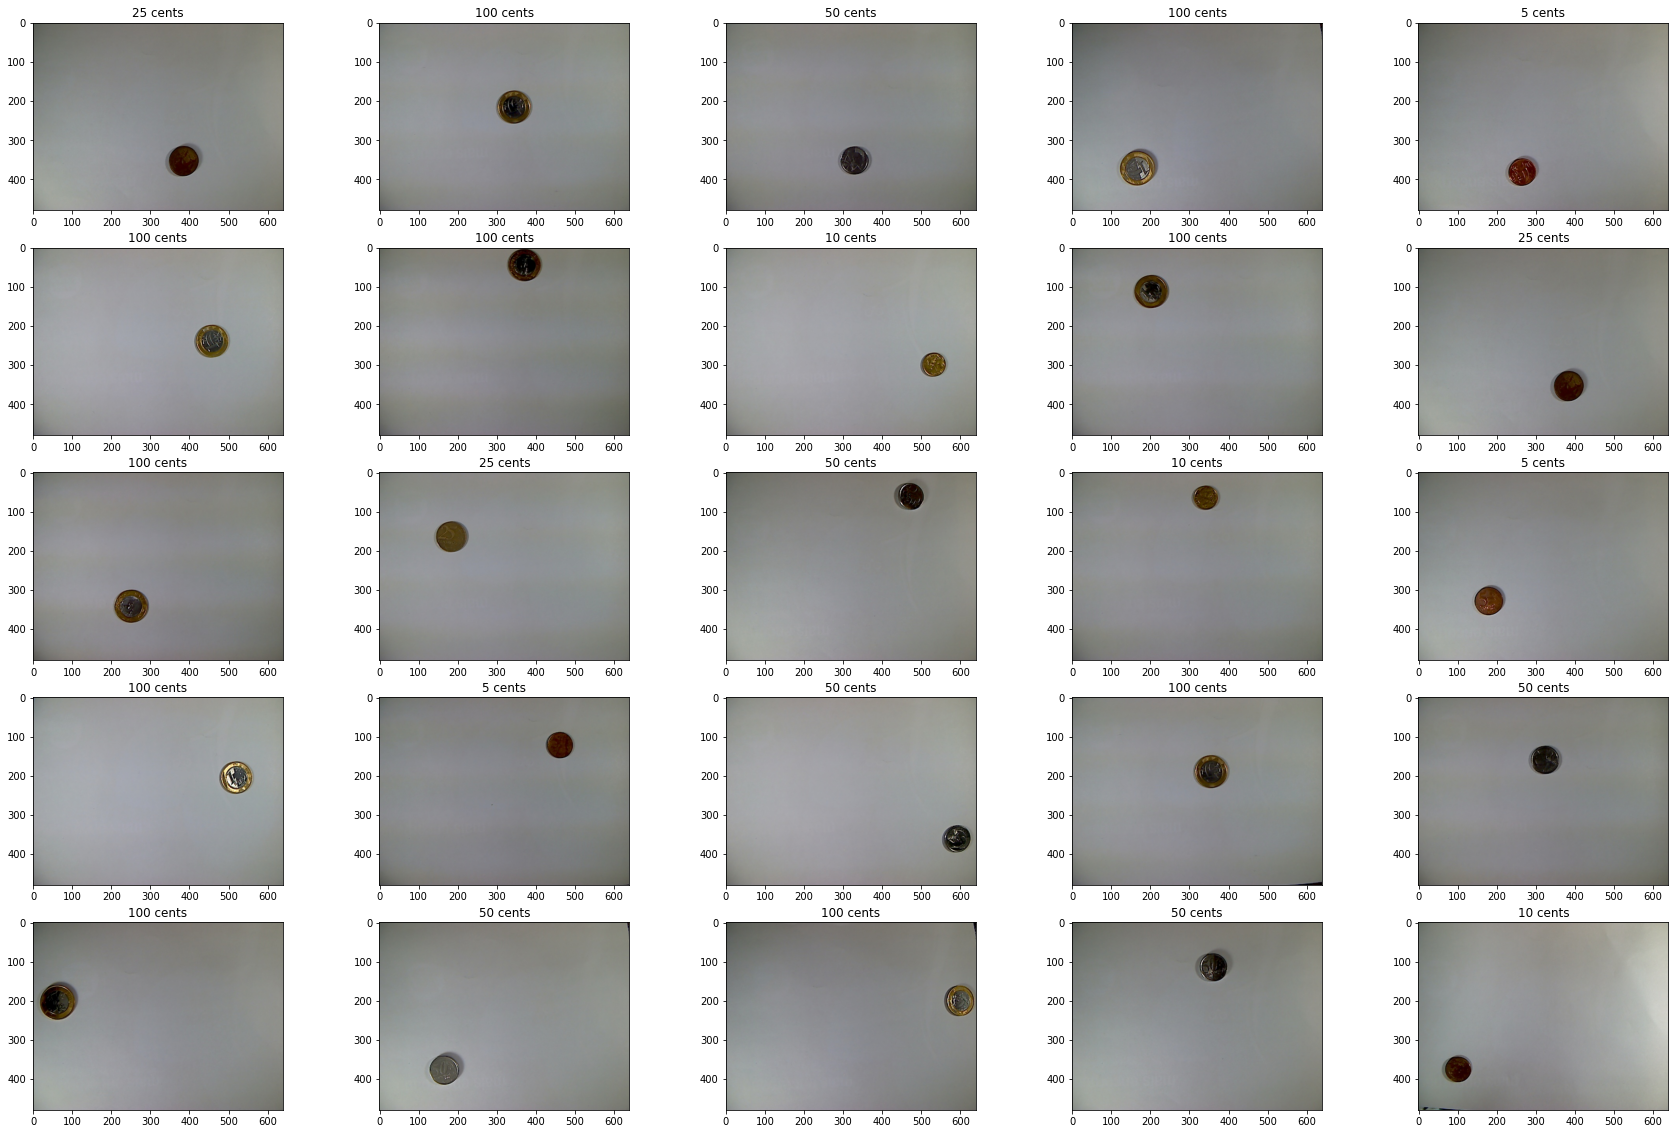

In [ ]:
# Inspecting test data
ax = plt.figure(figsize=(30, 20)).subplots(5, 5)
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, len(Y_test_labels))
        show_image(read_image(test_images[idx]), p=ax[i][j])
        ax[i][j].set_title(f'{Y_test_labels[idx]} cents')

# Extracting area of intrest from the images using template matching
Since the coins are placed in a light beackground I started preprocessing the images extracting the area of intrest using a binary threshold with the intuition that the coin will always be the darkest object in the image. Using the binary threshold alone and filtering out the darkest part of the image led to great results for most of the samples, but some samples are darker and present shadows, this led to bad results in extracting the area where the coin is placed. To solve this problem i applied a template matching using a mask with size 100x100 with a black circle in the middle. This method successfully extracts the coin from the image resulting in an image of size 100x100

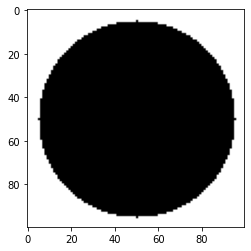

In [ ]:
s = 100
mask = np.ones((s, s)).astype(np.uint8) * 255
mask = cv2.circle(mask, (s//2, s//2), 45, (0,0,0), -1)
show_image(mask)

In [ ]:
def threshold_img(img, c=80):
    r, t = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), c, 200, cv2.THRESH_BINARY)
    return t


def extract(img, mask):
    img = read_image(img)
    t = threshold_img(img, c=76)
    result = cv2.matchTemplate(t, mask, 3)  #cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    startX, startY = max_loc
    endX = startX + mask.shape[0]
    endY = startY + mask.shape[1]
    return img[startY:endY, startX:endX]    
    

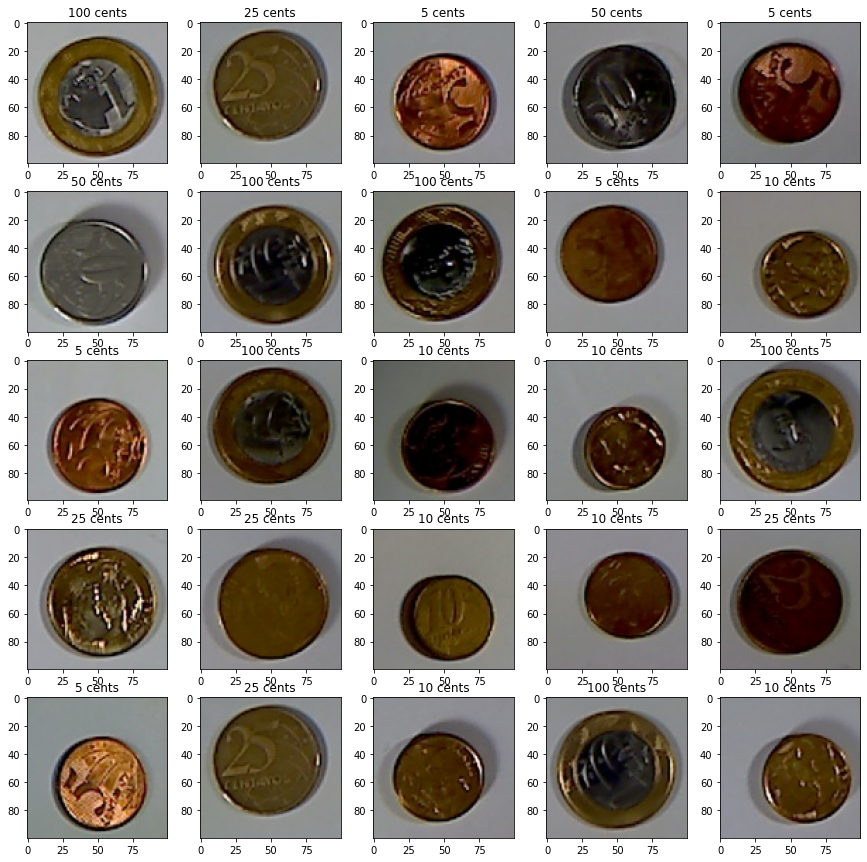

In [ ]:
# Inspecting train data
np.random.seed(4)

ax = plt.figure(figsize=(15, 15)).subplots(5, 5)
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, len(Y_train_labels))
        res = extract(train_images[idx], mask)
        show_image(res, ax[i][j])
        ax[i][j].set_title(f'{Y_train_labels[idx]} cents')


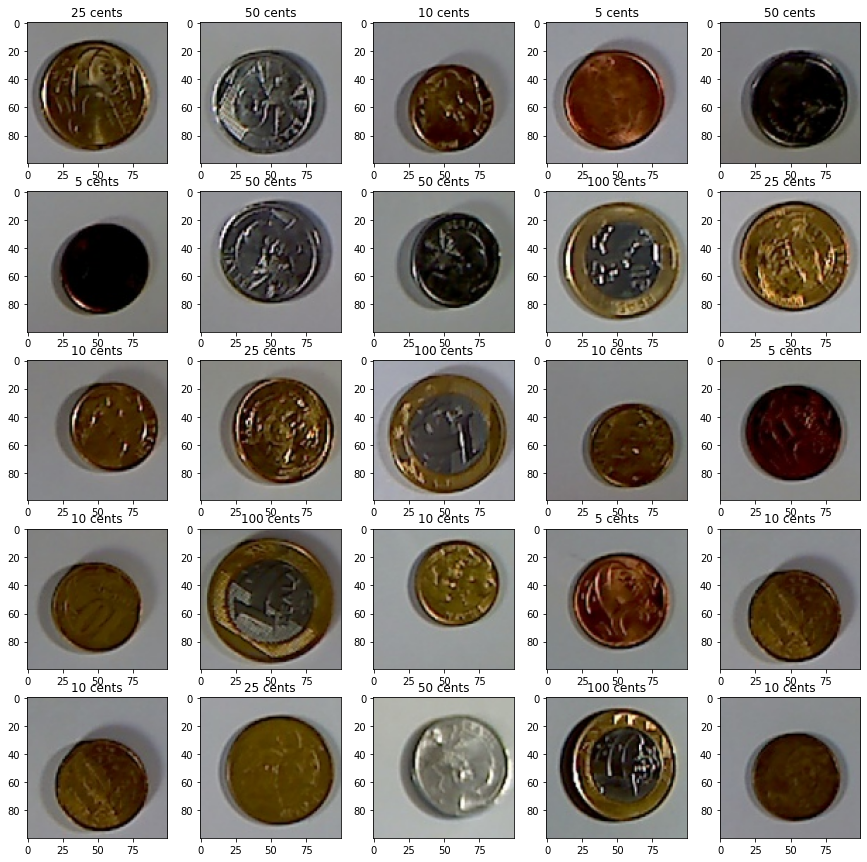

In [ ]:
# Inspecting test data
ax = plt.figure(figsize=(15, 15)).subplots(5, 5)
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, len(Y_test_labels))
        res = extract(test_images[idx], mask)
        show_image(res, ax[i][j])
        ax[i][j].set_title(f'{Y_test_labels[idx]} cents')

# Setting up training and testing datasets
- One hot encode label data (train and test)
- Load images in memory
- Use a part of the training set for validation
- Set up X and targets data using Tensorflow (train,validation and test datasets) 
- Normalize images

In [ ]:
X_train = np.array([extract(i, mask) for i in train_images])
X_test = np.array([extract(i, mask) for i in test_images])

In [ ]:
# loading labels
Y_train = [lbls.index(i) for i in Y_train_labels]
Y_test = [lbls.index(i) for i in Y_test_labels]

In [ ]:
# Setti up part of the train samples for validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=101)

print('Training samples:')
print(len(X_train))
print('Validation samples:')
print(len(X_val))

Training samples:
1752
Validation samples:
438


In [ ]:
# One hot encoding labels
Y_train = tf.one_hot(Y_train, 5)
Y_test = tf.one_hot(Y_test, 5)
Y_val = tf.one_hot(Y_val, 5)

50


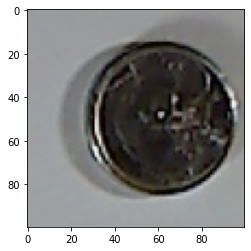

In [ ]:
idx = np.random.randint(len(X_val))

print(lbls[tf.argmax(Y_val[idx])])
show_image(X_val[idx])

In [ ]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    return image / 255., label

In [ ]:
np.random.seed(101)

batch_size = 32
ds_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).map(preprocess)
ds_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).map(preprocess)
ds_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).map(preprocess)


ds_train = ds_train.shuffle(len(ds_train))
ds_train = ds_train.batch(batch_size)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)

ds_val = ds_val.shuffle(len(ds_val))
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.prefetch(buffer_size=tf.data.AUTOTUNE)

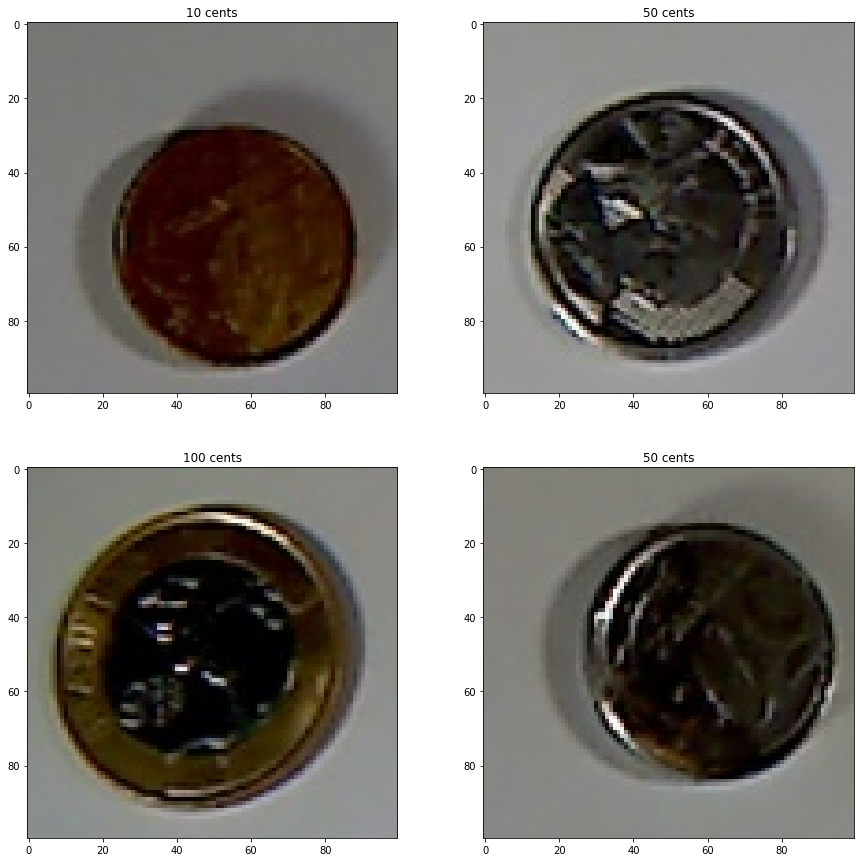

In [ ]:
# - Visualize training data
iter_data = iter(ds_train)
ax = plt.figure(figsize=(15, 15)).subplots(2, 2)
for i in range(2):
    for j in range(2):
        images, lab = next(iter_data)
        show_image(images[0].numpy(), p=ax[i][j])
        ax[i][j].set_title(f'{lbls[np.argmax(lab[0])]} cents')

# DenseNet inplementation
I found great results using a "minimized" DenseNet that instead of using four dense blocks (6, 12, 24, 16) it just uses three dense blocks (3, 6, 5).

A dense block consists in the repetiotion of BatchNorm -> ReLU -> Conv1x1 -> BatchNorm -> ReLU -> Conv3x3 a deternimated number of time. After a repetiotion the input that got feeded to this layer gets concatenated to the output and the feeded to the next repetition inside the block.

Here's a representation of how this is done: ![Alt text](https://zengzhanhang.com/Documents/ReadingNote/DenseNet/DenseNet.gif "Dense block connectivity")

Where h represents a repetition of BatchNorm -> ReLU -> Conv1x1 -> BatchNorm -> ReLU -> Conv3x3.

All dense block minus the last are followed by whats called a transition layer.
A trainsition layer BatchNorm -> ReLU -> Conv1x1 -> AvgPool2x2

The full architecture looks like this:
<pre>
 Layer         | Filters | block                |
 --------------|---------|----------------------|
 Convolution   | 32      | Conv7x7 stride=2     |
 --------------|---------|----------------------|
 Pooling       |         | MaxPool3x3 stride=2  |
 --------------|---------|----------------------|
 Dense Block 1 | 64      | Conv1x1              |
               | 16      | Conv3x3              | X3
 --------------|---------|----------------------|
 Transition 1  | 32      | Conv1x1              |
               |         | AvgPool2x2 stride=2  |
 --------------|---------|----------------------|
 Dense Block 2 | 64      | Conv1x1              | 
               | 16      | Conv3x3              | X6
 --------------|---------|----------------------|
 Transition 2  | 32      | Conv1x1              |
               |         | AvgPool2x2 stride=2  |
 --------------|---------|----------------------|
 Dense Block 3 | 64      | Conv1x1              |
               | 16      | Conv3x3              | X5
 --------------|---------|----------------------|
 Pooling       |         | GlobalAvgPool        |
 --------------|---------|----------------------|
 Output        |         | Softmax              |
 --------------|---------|----------------------|
 </pre>

Al convolutions minus the first one represent the sequence BatchNorm -> ReLU -> Conv 

In [ ]:
def bn_rl_conv(x, filters, kernel=1, strides=1):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel, strides=strides, padding='same')(x)
    return x


def dense_block(x, repetitions, filters=32):
    for _ in range(repetitions):
        y = bn_rl_conv(x, 4*filters)
        y = bn_rl_conv(y, filters, 3)
        x = concatenate([y, x])

    return x


def transition_layer(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] / 2)
    x = AveragePooling2D(2, strides=2, padding='same')(x)
    return x


def densenet(input_shape, configuration, num_classes=5, initial_filters=64, dense_block_filters=32):
    inp = Input(input_shape)
    x = Conv2D(initial_filters, 7, strides=2, padding='same')(inp)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    for repetitions in configuration:
        d = dense_block(x, repetitions, dense_block_filters)
        x = transition_layer(d)

    x = GlobalAveragePooling2D()(d)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inp, output)
    return model

In [ ]:
model = densenet((100,100,3), (3,6,5), initial_filters=32, dense_block_filters=16)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_32 (Conv2D)             (None, 50, 50, 32)   4736        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 25, 25, 32)  0           ['conv2d_32[0][0]']              
                                                                                                  
 batch_normalization_31 (BatchN  (None, 25, 25, 32)  128         ['max_pooling2d_1[0][0]']  

# Preparing training
I'm using categorical corss entropy for my loss function and an accuracy metric returning the percentage of samples that have been classified correctly.

The model is trained for 100 epochs with a learningrate of 0.00001 using an Adam optimizer

In [ ]:
# - Accuracy function
def accuracy(y_true, y_pred):
    pred_class = tf.argmax(y_pred, 1)
    correct_prediction = tf.equal(pred_class, tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [ ]:
# - Define loss function
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

train_epoch = 100
learning_rate = 0.00001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# - Training step
@tf.function
def one_train_step(x, y_true):
    with tf.GradientTape() as g:
        y_pred = model(x, training=True)
        ce_loss = loss_fn(y_true, y_pred) 
        loss = ce_loss
        acc = accuracy(y_true, y_pred)
    gradients = g.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc
 

# - Validation Step
@tf.function
def one_val_step(x, y_true):
    y_pred = model(x, training=False)
    loss = loss_fn(y_true, y_pred)
    acc = accuracy(y_true, y_pred)
    return loss, acc


# Training loop

In [ ]:
# - Training Loop
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

loss = 0
acc = 0

for i in range(train_epoch):

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    ds_train = ds_train.shuffle(len(ds_train))

    print('Epoch ' + str(i + 1))

    # Train step
    for i, data in enumerate(ds_train):
        images, labels = data
        labels = tf.cast(labels, tf.int64)
        loss, acc = one_train_step(images, labels)
        train_loss += loss
        train_acc += acc
    train_loss_history += [train_loss/len(ds_train)]
    train_acc_history += [train_acc/len(ds_train)]

    # Validation step
    for i, data in enumerate(ds_val):
        images, labels = data
        labels = tf.cast(labels, tf.int64)
        loss, acc = one_val_step(images, labels)
        val_loss += loss
        val_acc += acc
    val_loss_history += [val_loss/len(ds_val)]
    val_acc_history += [val_acc/len(ds_val)]

    print('train_loss: ', tf.get_static_value(train_loss/len(ds_train)),
          'train_acc: ', tf.get_static_value(train_acc/len(ds_train)),
          'val_loss: ', tf.get_static_value(val_loss/len(ds_val)),
          'val_acc: ', tf.get_static_value(val_acc/len(ds_val)))

Epoch 1
train_loss:  1.610823 train_acc:  0.26344696 val_loss:  1.6161376 val_acc:  0.16030845
Epoch 2
train_loss:  1.4374771 train_acc:  0.5534091 val_loss:  1.6155349 val_acc:  0.16030845
Epoch 3
train_loss:  1.3102632 train_acc:  0.6625 val_loss:  1.6151348 val_acc:  0.2867289
Epoch 4
train_loss:  1.1988529 train_acc:  0.7034091 val_loss:  1.6073824 val_acc:  0.2315341
Epoch 5
train_loss:  1.0983095 train_acc:  0.7375 val_loss:  1.5403913 val_acc:  0.23478083
Epoch 6
train_loss:  0.9924849 train_acc:  0.78238636 val_loss:  1.4401063 val_acc:  0.27658278
Epoch 7
train_loss:  0.9154296 train_acc:  0.7992425 val_loss:  1.2840688 val_acc:  0.4299919
Epoch 8
train_loss:  0.8439797 train_acc:  0.83371216 val_loss:  1.1165239 val_acc:  0.57041395
Epoch 9
train_loss:  0.779178 train_acc:  0.8543561 val_loss:  0.9173626 val_acc:  0.73579544
Epoch 10
train_loss:  0.71332926 train_acc:  0.87784094 val_loss:  0.75498086 val_acc:  0.8118912
Epoch 11
train_loss:  0.6701187 train_acc:  0.8839015 v

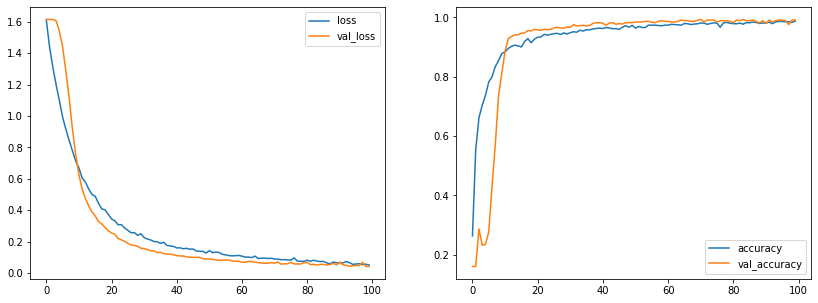

In [ ]:
ax = plt.figure(figsize=(14, 5)).subplots(1, 2)
ax[0].plot(train_loss_history)
ax[0].plot(val_loss_history)
ax[0].legend(['loss', 'val_loss'])

ax[1].plot(train_acc_history)
ax[1].plot(val_acc_history)
ax[1].legend(['accuracy', 'val_accuracy'])

# Conclusions
The model is learning without overfitting the data. At epoch = 13 it already has an accuracy above 90% and the validation error and accuracy don't diverge from the training during the latest epochs.

On the testing set the model gets an accuracy of almost 99% with only 7 misclassified samples over the 544 samples in the dataset

# Visualizing wrong predictions



In [ ]:
predictions = []
true_y = []

wrong_predictions = []

for data in ds_test:
    x, y = data
    pred = np.argmax(model.predict(tf.reshape(x, (1, 100, 100, 3))), axis=1)
    tr = np.argmax(y)
    if pred != tr:
        wrong_predictions.append(x)
        wrong_predictions.append(pred)
        wrong_predictions.append(tr)
  
    predictions = np.append(predictions, pred)
    true_y = np.append(true_y, tr)

test_accuracy = accuracy_score(true_y, predictions)
print(test_accuracy)
print(f'{len(wrong_predictions) // 3} wrong predictions')

0.9871323529411765
7 wrong predictions


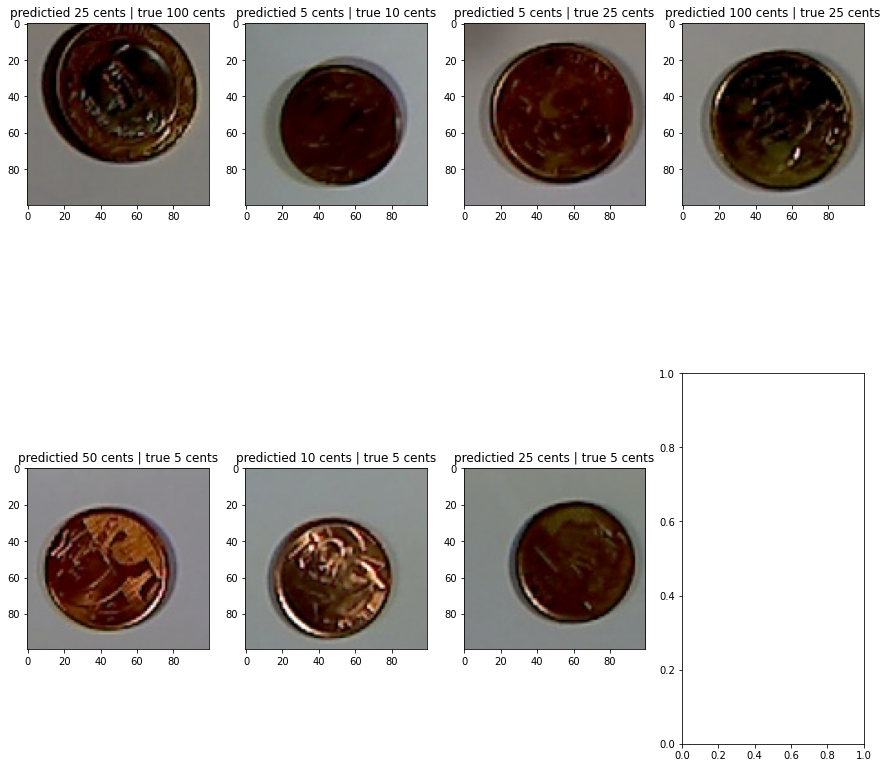

In [ ]:
ax = plt.figure(figsize=(15, 15)).subplots(2, 4)
idx = 0
for i in range(2):
    for j in range(4):
        if (i + 1) * (j + 1) < len(wrong_predictions) // 3:
            img = wrong_predictions[idx]
            pred = wrong_predictions[idx+1]
            true = wrong_predictions[idx+2]
            show_image(img, p=ax[i][j])
            ax[i][j].set_title(f'predictied {lbls[int(pred)]} cents | true {lbls[int(true)]} cents')
            idx += 3

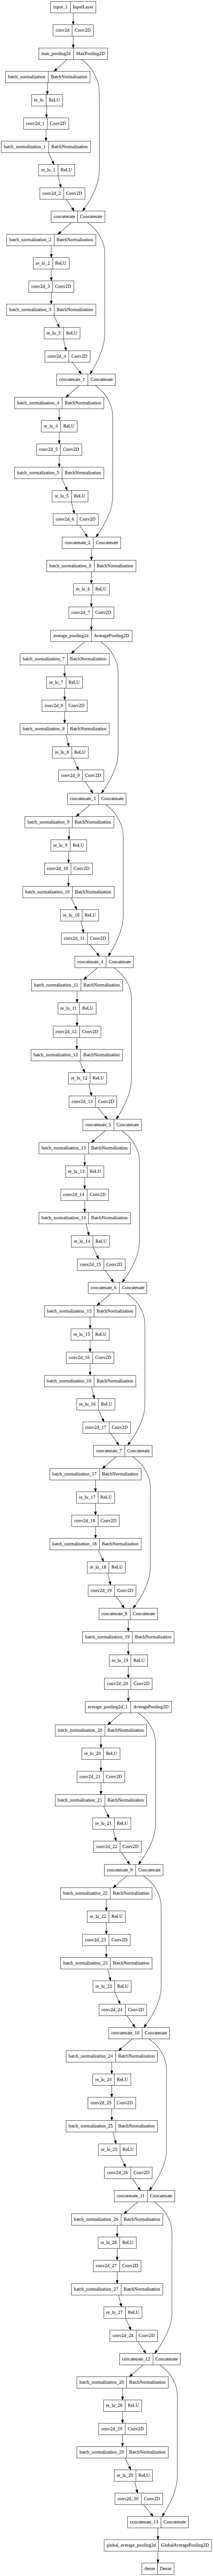

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)